In [1]:
from services import DatabaseService as db
from services import OracleService as ora
import pandas as pd
import seaborn as sns
pd.set_option("display.max_rows", 30, "display.max_columns", 30)
pd.set_option("max_colwidth", None)

# Get all stored test sentences
df = db.get_test_sentences()
df[['id', 'sentence', 'date', 'correct_answer_label', 'model_name', 'note', 'strength']]

/ResultStore/persistence/DBConnection.py:108: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query("Select * from test_sentence", self.__connection)


,id,sentence,date,correct_answer_label,model_name,note,strength
0,1,are strawberries bigger than ice bears?,2025-03-27,false,OLLAMA,ollama-llama3.1-t2,2
1,2,Can you drink alcohol in public in Denmark?,2025-03-27,true,OLLAMA,ollama-llama3.1-t2,2
2,3,are strawberries bigger than ice bears?,2025-03-27,false,OLLAMA,ollama-llama3.2-t2,2
3,4,Can you drink alcohol in public in Denmark?,2025-03-27,true,OLLAMA,ollama-llama3.2-t2,2
4,5,are strawberries bigger than ice bears?,2025-03-27,false,OLLAMA,ollama-llama2-uncensored-t2,2
5,6,Can you drink alcohol in public in Denmark?,2025-03-27,true,OLLAMA,ollama-llama2-uncensored-t2,2
6,7,are strawberries bigger than ice bears?,2025-03-27,false,OLLAMA,ollama-deepseek-r1-t2,2
7,8,Can you drink alcohol in public in Denmark?,2025-03-27,true,OLLAMA,ollama-deepseek-r1-t2,2
8,9,are strawberries bigger than ice bears?,2025-03-27,false,OLLAMA,ollama-mistral-t2,2
9,10,Can you drink alcohol in public in Denmark?,2025-03-27,true,OLLAMA,ollama-mistral-t2,2


In [2]:
# Let's find all distinct LLMs
# We do this via the `note` column, but the `model_name` would also be a candidate
distinguisher = 'note'
llms = df[distinguisher].unique()
llms

array(['ollama-llama3.1-t2', 'ollama-llama3.2-t2',
       'ollama-llama2-uncensored-t2', 'ollama-deepseek-r1-t2',
       'ollama-mistral-t2', 'ollama-starling-lm-t2'], dtype=object)

In [3]:
# Create a dictionary with model names as keys and their sentences as values
llm_sentence_map = {}
for llm in llms:
    llm_sentences = df[df[distinguisher] == llm]
    llm_sentence_map[llm] = llm_sentences['id'].to_list()
    #print(f'Sentences for {llm}:')
    #print(llm_sentences[['id', 'sentence', distinguisher]])
print(f'LLM -> Sentences: {llm_sentence_map}')

LLM -> Sentences: {'ollama-llama3.1-t2': [1, 2], 'ollama-llama3.2-t2': [3, 4], 'ollama-llama2-uncensored-t2': [5, 6], 'ollama-deepseek-r1-t2': [7, 8], 'ollama-mistral-t2': [9, 10], 'ollama-starling-lm-t2': [11, 12]}


In [4]:
# Get all test queries for a specific test_sentence ID
# This is primarily for illustration purposes - we will later proceed using all queries from all test runs/sentences
sentence_id = 1
queries = db.get_test_queries_by_sentence_id(sentence_id)
queries

/ResultStore/persistence/DBConnection.py:128: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(


,sentence_id,sentence,correct_answer_label,query_id,modified_question,new_response
0,1,are strawberries bigger than ice bears?,false,1,are strawberries bigger than water ice bear ?? Return a JSON boolean.,False
1,1,are strawberries bigger than ice bears?,false,2,are strawberries larger than sparkler bears ?? Return a JSON boolean.,False
2,1,are strawberries bigger than ice bears?,false,3,are strawberries large than ice bear ?? Return a JSON boolean.,False
3,1,are strawberries bigger than ice bears?,false,4,are strawberry bigger than sparkler bears ?? Return a JSON boolean.,False
4,1,are strawberries bigger than ice bears?,false,5,are strawberry larger than ice bear ?? Return a JSON boolean.,False
5,1,are strawberries bigger than ice bears?,false,6,are strawberry large than water ice bears ?? Return a JSON boolean.,False
6,1,are strawberries bigger than ice bears?,false,7,are strawberry mark bigger than ice bears ?? Return a JSON boolean.,False
7,1,are strawberries bigger than ice bears?,false,8,are strawberry mark larger than water ice bear ?? Return a JSON boolean.,False
8,1,are strawberries bigger than ice bears?,false,9,are strawberry mark large than sparkler bear ?? Return a JSON boolean.,False


/ResultStore/persistence/DBConnection.py:116: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(


,count
false,39
true,56
undefined,13


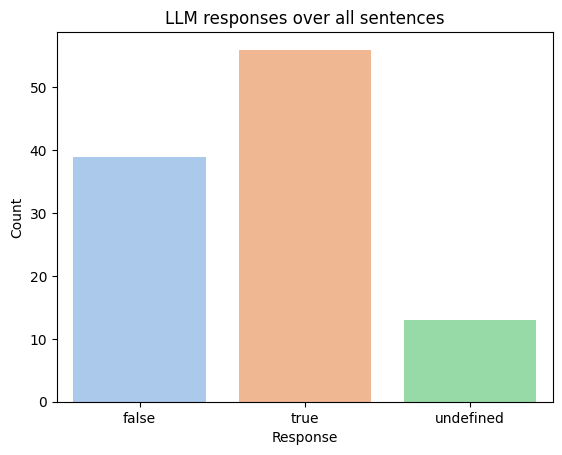

In [5]:
# Just a little preliminary check - plot the number of LLM responses (true/false/undefined)

distribution = ora.preliminary_check()
df = pd.DataFrame.from_dict(distribution, orient='index', columns=['count'])
ax = sns.barplot(data=df, x=df.index, y='count', palette='pastel', hue=df.index)
ax.set(ylabel='Count', xlabel='Response', title='LLM responses over all sentences')
df

In [6]:
# Let us get back to business; we need to normalize the LLM responses by applying an oracle
# We will first retrieve all queries for all sentences
queries = db.get_test_queries()
# Then we apply the oracle...
queries = ora.apply_oracle(queries, ora.initial_oracle_function)
# ... and save the normalized version
ora.save_oracle_results(queries)
queries


/ResultStore/persistence/DBConnection.py:116: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query(


,sentence_id,sentence,correct_answer_label,query_id,modified_question,new_response,result
0,1,are strawberries bigger than ice bears?,false,1,are strawberries bigger than water ice bear ?? Return a JSON boolean.,False,false
1,1,are strawberries bigger than ice bears?,false,2,are strawberries larger than sparkler bears ?? Return a JSON boolean.,False,false
2,1,are strawberries bigger than ice bears?,false,3,are strawberries large than ice bear ?? Return a JSON boolean.,False,false
3,1,are strawberries bigger than ice bears?,false,4,are strawberry bigger than sparkler bears ?? Return a JSON boolean.,False,false
4,1,are strawberries bigger than ice bears?,false,5,are strawberry larger than ice bear ?? Return a JSON boolean.,False,false
...,...,...,...,...,...,...,...
103,12,Can you drink alcohol in public in Denmark?,true,104,can you imbibe alcoholic drink in public in kingdom of denmark ?? Return a JSON boolean.,"{""answer"": true, ""explanation"": ""In the Kingdom of Denmark, which includes Denmark, Greenland, and the Faroe Islands, there are some restrictions on consuming alcoholic beverages in public places. However, it is generally allowed under certain conditions.""\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n",undefined
104,12,Can you drink alcohol in public in Denmark?,true,105,can you imbibe alcoholic beverage in populace in danmark ?? Return a JSON boolean.,True,true
105,12,Can you drink alcohol in public in Denmark?,true,106,can you booze alcohol in public in danmark ?? Return a JSON boolean.,False,false
106,12,Can you drink alcohol in public in Denmark?,true,107,can you booze alcoholic drink in populace in denmark ?? Return a JSON boolean.,True,true


In [7]:
# Let's check for LLM weirdness
# This returns all queries where the response could not be parsed as true or false
unparseables = queries[queries['result'] == 'undefined'][
    ['sentence_id', 'query_id', 'sentence', 'modified_question', 'new_response', 'correct_answer_label']
]
# You might want to do something here with these weird cases - 
# maybe calculate the proportion of undefined responses by model?
unparseables

,sentence_id,query_id,sentence,modified_question,new_response,correct_answer_label
56,7,57,are strawberries bigger than ice bears?,are strawberries large than ice bear ?? Return a JSON boolean.,"{""error"":""Please provide a valid question in proper format.""}\n",false
66,8,67,Can you drink alcohol in public in Denmark?,can you imbibe alcohol in world in denmark ?? Return a JSON boolean.,"{""error"":""Invalid request""}\n",true
67,8,68,Can you drink alcohol in public in Denmark?,can you imbibe alcoholic drink in public in kingdom of denmark ?? Return a JSON boolean.,"{""error"":""You cannot request incremental changes to your own knowledge base.""}\n",true
90,11,91,are strawberries bigger than ice bears?,are strawberries bigger than water ice bear ?? Return a JSON boolean.,"{""answer"":""No, strawberries are not bigger than water ice bears.""}\n",false
91,11,92,are strawberries bigger than ice bears?,are strawberries larger than sparkler bears ?? Return a JSON boolean.,"{""answer"":""Yes, generally speaking.""}\n",false
92,11,93,are strawberries bigger than ice bears?,are strawberries large than ice bear ?? Return a JSON boolean.,"{""answer"":""No, strawberries are not larger than ice bears.""}\n",false
93,11,94,are strawberries bigger than ice bears?,are strawberry bigger than sparkler bears ?? Return a JSON boolean.,"{""answer"":""No, strawberries are not bigger than sparkler bears.""}\n",false
94,11,95,are strawberries bigger than ice bears?,are strawberry larger than ice bear ?? Return a JSON boolean.,"{""answer"":""No, strawberries are not larger than Ice Bear.""}\n",false
96,11,97,are strawberries bigger than ice bears?,are strawberry mark bigger than ice bears ?? Return a JSON boolean.,"{""answer"":""No, strawberry marks are not bigger than ice bears.""}\n",false
97,11,98,are strawberries bigger than ice bears?,are strawberry mark larger than water ice bear ?? Return a JSON boolean.,"{""answer"":""It depends on the specific products being compared.""}\n",false


In [8]:
# We split the queries by the LLM they came from
llm_queries = {}
for llm, sentence_ids in llm_sentence_map.items():
    print(f'Filtering queries for LLM {llm} with sentence IDs {sentence_ids}')
    llm_queries[llm] = queries[queries['sentence_id'].isin(sentence_ids)]
#llm_queries

Filtering queries for LLM ollama-llama3.1-t2 with sentence IDs [1, 2]
Filtering queries for LLM ollama-llama3.2-t2 with sentence IDs [3, 4]
Filtering queries for LLM ollama-llama2-uncensored-t2 with sentence IDs [5, 6]
Filtering queries for LLM ollama-deepseek-r1-t2 with sentence IDs [7, 8]
Filtering queries for LLM ollama-mistral-t2 with sentence IDs [9, 10]
Filtering queries for LLM ollama-starling-lm-t2 with sentence IDs [11, 12]


In [9]:
# Let's calculate precision, recall, f1 score and consistency per LLM
precisions = {llm: ora.get_precision(queries) for llm, queries in llm_queries.items()}
print(f'Precisions: \n{precisions}')
recalls = {llm: ora.get_recall(queries) for llm, queries in llm_queries.items()}
print(f'Recalls: \n{recalls}')
f1_scores = {llm: ora.get_f1_score(queries) for llm, queries in llm_queries.items()}
print(f'F1 scores: \n{f1_scores}')
consistencies = {llm: ora.get_consistency(queries) for llm, queries in llm_queries.items()}
print(f'Consistencies: \n{consistencies}')

Precisions: 
{'ollama-llama3.1-t2': 1.0, 'ollama-llama3.2-t2': 0.7777777777777778, 'ollama-llama2-uncensored-t2': 0.5, 'ollama-deepseek-r1-t2': 0.7777777777777778, 'ollama-mistral-t2': 1.0, 'ollama-starling-lm-t2': 0.8571428571428571}
Recalls: 
{'ollama-llama3.1-t2': 0.6666666666666666, 'ollama-llama3.2-t2': 0.7777777777777778, 'ollama-llama2-uncensored-t2': 1.0, 'ollama-deepseek-r1-t2': 1.0, 'ollama-mistral-t2': 0.7777777777777778, 'ollama-starling-lm-t2': 0.8571428571428571}
F1 scores: 
{'ollama-llama3.1-t2': 0.8, 'ollama-llama3.2-t2': 0.7777777777777778, 'ollama-llama2-uncensored-t2': 0.6666666666666666, 'ollama-deepseek-r1-t2': 0.8750000000000001, 'ollama-mistral-t2': 0.8750000000000001, 'ollama-starling-lm-t2': 0.8571428571428571}
Consistencies: 
{'ollama-llama3.1-t2': np.float64(0.8333333333333333), 'ollama-llama3.2-t2': np.float64(0.5), 'ollama-llama2-uncensored-t2': np.float64(1.0), 'ollama-deepseek-r1-t2': np.float64(0.7222222222222222), 'ollama-mistral-t2': np.float64(0.88888

(0.0, 1.0)

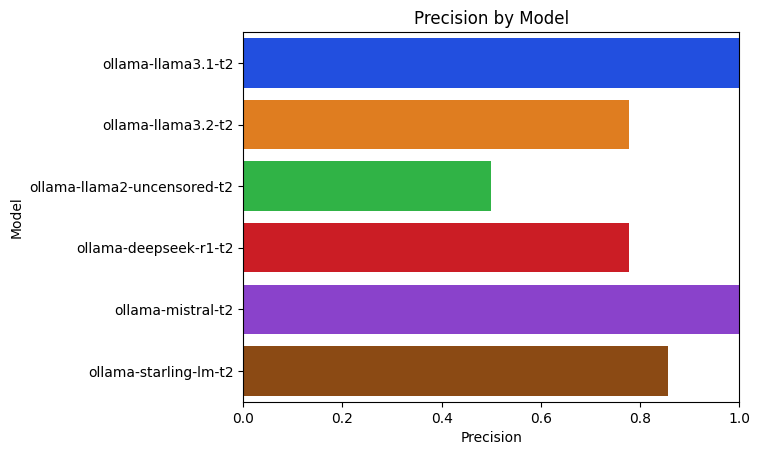

In [10]:
# Plot precision
# Precision is the ratio of true positives over the sum of true positives and true negatives

precisions_df = pd.DataFrame.from_dict(precisions, orient='index', columns=['precision'])
ax = sns.barplot(data=precisions_df, x='precision', y=precisions_df.index, palette='bright', hue=precisions_df.index)
ax.set(ylabel='Model', xlabel='Precision', title='Precision by Model')
ax.set_xlim(0.0, 1.0)

(0.0, 1.0)

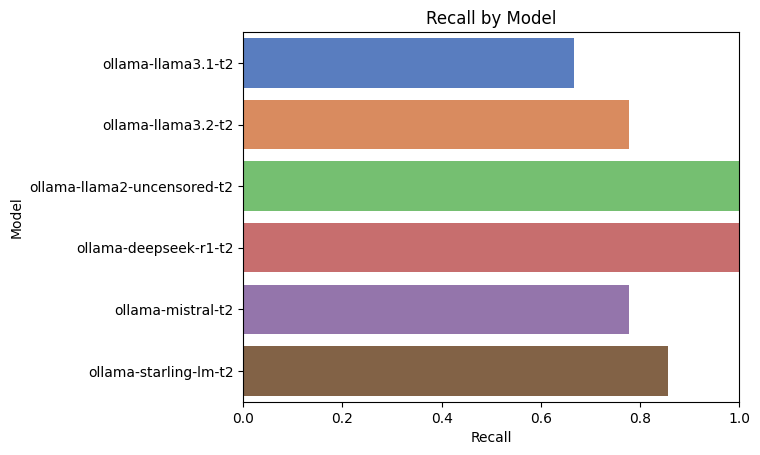

In [11]:
# Plot recall
# Recall is the ratio of true positives over the sum of true positives and false negatives

recalls_df = pd.DataFrame.from_dict(recalls, orient='index', columns=['recall'])
ax = sns.barplot(data=recalls_df, x='recall', y=recalls_df.index, palette='muted', hue=recalls_df.index)
ax.set(ylabel='Model', xlabel='Recall', title='Recall by Model')
ax.set_xlim(0.0, 1.0)

(0.0, 1.0)

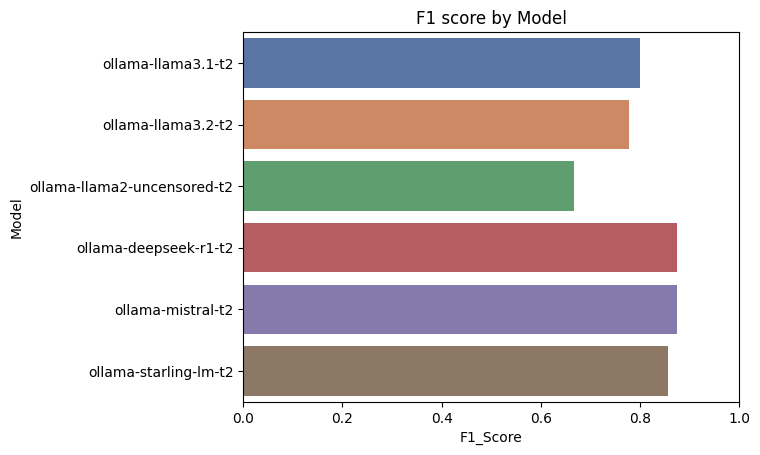

In [12]:
# Plot F1 score
# The F1 score is 2*(precision * recall) / (precision + recall)

f1_scores_df = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['f1'])                                                                                                                              
ax = sns.barplot(data=f1_scores_df, x='f1', y=f1_scores_df.index, palette='deep', hue=f1_scores_df.index)                                                                                                    
ax.set(ylabel='Model', xlabel='F1_Score', title='F1 score by Model')
ax.set_xlim(0.0, 1.0)

(0.0, 1.0)

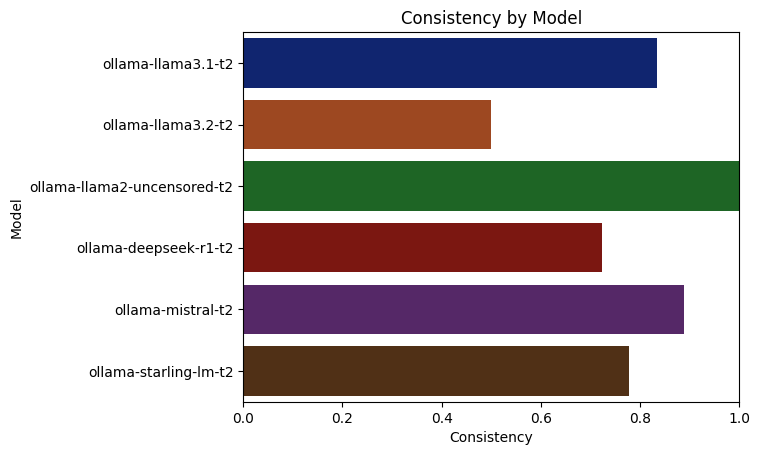

In [13]:
# Plot consistency
# The consistency measures the ratio of model responses that are identical to the responses to the first query
# A model that always returns the same response (regardless of how correct it is) will have a consistency of 1.0
# while a model that returns "true" 50% of the time will have a value of 0.5.
# It is possible to have a lower value if the rensponse to later, mutated queries is almost always different from
# the response to the original (unmodified or only minimally modified) sentence.

consistencies_df = pd.DataFrame.from_dict(consistencies, orient='index', columns=['consistency'])                                                                                                                   
ax = sns.barplot(data=consistencies_df, x='consistency', y=consistencies_df.index, palette='dark', hue=consistencies_df.index)                                                                                     
ax.set(ylabel='Model', xlabel='Consistency', title='Consistency by Model')
ax.set_xlim(0.0, 1.0)

In [14]:
# Here are some examples that should help you get started with exporting results as you need them

# Exporting test sentences
sentences = db.get_test_sentences()
sentence_ids = sentences.loc[sentences["sentence"].isin(["can you drink alcohol in public in denmark", "do new zealand and australia have the same flag"])]
sentence_ids.to_csv("sentences.csv")

# Exporting queries by sentence
query_dfs =[]
for index, sentence_id in enumerate(sentence_ids["id"].values.tolist()):
    db.get_test_queries_by_sentence_id(sentence_id).to_csv("queries" + str(index) +".csv")

# Exporting queries by query ID
query_ids = [1, 2, 3]
queries.loc[queries["query_id"].isin(query_ids)].to_csv("results.csv")

/ResultStore/persistence/DBConnection.py:108: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return sqlio.read_sql_query("Select * from test_sentence", self.__connection)
